In [ ]:
# I used python kernel 3.10.15 + nvidia RTX 3090 + cuda 12.1 in local machine

# install ralated modules
%pip install torch==2.1.1 torchvision==0.16.1   # compatible version of pytorch and torchvision for mamba-ssm 
%pip install causal-conv1d==1.1.1   # causal dpthwise conv 1d  module in CUDA with pytorch
%pip install mamba-ssm  # Mamba block module

In [2]:
# import modules

import torch
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import tqdm

from mamba_ssm import Mamba

import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
import matplotlib.pyplot as plt

import copy
from collections import defaultdict

In [3]:
# Check environments
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
torch.cuda.is_available()

torch:  2.1 ; cuda:  cu121


True

In [4]:
# Get original data
!mkdir ./datasets
!mkdir ./datasets/adult
!wget -nc https://archive.ics.uci.edu/static/public/2/adult.zip
!unzip -o ./adult.zip -d ./datasets/adult
!cp -rf ./datasets/adult/adult.data ./datasets/adult/data_processed.csv

mkdir: `./datasets' 디렉터리를 만들 수 없습니다: 파일이 있습니다
mkdir: `./datasets/adult' 디렉터리를 만들 수 없습니다: 파일이 있습니다
‘adult.zip’ 파일이 이미 있습니다. 가져오지 않음.

Archive:  ./adult.zip
  inflating: ./datasets/adult/Index  
  inflating: ./datasets/adult/adult.data  
  inflating: ./datasets/adult/adult.names  
  inflating: ./datasets/adult/adult.test  
  inflating: ./datasets/adult/old.adult.names  


In [5]:
# Set Configuration for MambaTab
config={
    'DATASET_NAME':'adult',
    'SEED':15, # random seed 지정
    'BATCH':100,
    'LR':0.0001,
    'EPOCH':1000,
    'MAMBA_SSM_DIM':32,  # MAMBA model의 dimension 설정 (d_model: Selective Structured State Machine에 담을 최대 Dimension)
    'device':'cuda'}

In [6]:
# data load and preparing

def read_data(dataset_name):
    data=pd.read_csv('./datasets/'+dataset_name+'/data_processed'+'.csv')
    
    # fill null values
    for col in data.columns: 
        #data[col].fillna(data[col].mode()[0], inplace=True)
        data[col] = data[col].fillna(data[col].mode()[0])

    # categorical encoder: 문자열인 경우 소문자로 통일하고, 숫자로 인코딩 처리
    for c in data.columns:
        if is_string_dtype(data[c]):
            data[c]=data[c].str.lower()
            enc=OrdinalEncoder()
            cur_data=np.array(data[c])
            cur_data=np.reshape(cur_data,(cur_data.shape[0],1))
            data[c] = enc.fit_transform(cur_data)

    # 마지막 column을 lable로 처리
    y_data=data[data.columns[-1]]

    x_data = data.drop(labels = [data.columns[-1]],axis = 1)
    x_data=MinMaxScaler().fit_transform(x_data) # 데이터 스케일링 처리
    x_data,y_data=np.array(x_data),np.array(y_data)
    
    return x_data,y_data

In [7]:
# MambaTab Class

class MambaTab(torch.nn.Module):

    def __init__(self,input_features,n_class,intermediate_representation=config['MAMBA_SSM_DIM']):
        super(MambaTab, self).__init__()
        self.linear_layer=torch.nn.Linear(input_features,intermediate_representation)
        self.relu=torch.nn.ReLU()
        self.layer_norm=torch.nn.LayerNorm(intermediate_representation)

        self.mamba=Mamba(d_model=intermediate_representation, d_state=32, d_conv=4, expand=2) # to fine-tuning
        self.output_layer=torch.nn.Linear(intermediate_representation,n_class)
    
    def forward(self, x):
         x=self.linear_layer(x)
         x=self.layer_norm(x)
         x=self.relu(x)
         x=self.mamba(x)
         x=self.output_layer(x)
         return x

In [8]:
# Training function

def train_model(model,config, dataloader):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    early_stopping_counter=0

    optimizer=torch.optim.Adam(model.parameters(),lr=config['LR'])  # Optimizer setting: Adam
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['EPOCH'], eta_min=0,verbose=False)
    loss_fn=torch.nn.BCEWithLogitsLoss()    # 이진분류 처리를 위해 BCEWithLogitLoss 함수 사용
  
    for epoch in tqdm.tqdm(range(config['EPOCH'])):
        if early_stopping_counter>=5:
          break
        
        for phase in ['train', 'val']:      
            if phase == 'train':               
                model.train()  
            else:
                model.eval()  
            
            metrics = defaultdict(float)
            epoch_samples = 0
          
            for btch,feed_dict in enumerate(dataloader[phase]):
                inputs=feed_dict[0]
                inputs=inputs.unsqueeze(0)
                labels=feed_dict[1]
                
                inputs = inputs.type(torch.FloatTensor)
                inputs = inputs.to(config['device'])
                labels = labels.type(torch.FloatTensor)
                labels = labels.to(config['device'])
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  
                    outputs=outputs.squeeze()  
                    loss=loss_fn(outputs,labels)
                    metrics['loss']+=loss.item()
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()  
                
                epoch_samples += 1 
           
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'val':
           
                if epoch_loss<best_loss:
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_loss=epoch_loss
                    early_stopping_counter=0
                else:
                    early_stopping_counter+=1

        scheduler.step()           
    
    model.load_state_dict(best_model_wts)       
    
    return model

In [9]:
# Test and evaluation

def test_result(test_model, test_dataloader):

  test_model.eval()

  all_probs=[]
  all_labels=[]
  
  sig=torch.nn.Sigmoid()  # 이진분류 처리를 위해 BCEWithLogitLoss 함수와 함께 Sigmoid 사용

  for inputs,labels in test_dataloader['test']:
    inputs = inputs.unsqueeze(0)
    inputs = inputs.type(torch.FloatTensor)
    inputs = inputs.to(config['device'])
    
    labels = labels.to(config['device'])

    with torch.set_grad_enabled(False):
      outputs = test_model(inputs)
      outputs=outputs.squeeze()
      outputs=sig(outputs)
                           
      outputs=outputs.cpu().detach().numpy()
      labels=labels.cpu().detach().numpy()

      for i in range(outputs.shape[0]):
         all_labels.append(labels[i])
         all_probs.append(outputs[i])
         
  auroc_score = roc_auc_score(all_labels,all_probs)
  print("AUROC score: ", auroc_score)

  return all_labels, all_probs, auroc_score


In [10]:
# Data loading and data split

x_data,y_data=read_data(dataset_name=config['DATASET_NAME'])

x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.2,random_state=config['SEED'],stratify=y_data,shuffle=True)
val_size=int(len(y_data)*0.1)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=val_size,random_state=config['SEED'],stratify=y_train, shuffle=True)

print("Train:",x_train.shape)
print("Val:",x_val.shape)
print("Test:",x_test.shape)

Train: (22792, 14)
Val: (3256, 14)
Test: (6512, 14)


In [11]:
# Data Lodader wrapper

class TabularDataLoader(Dataset):

    def __init__(self,length,data_type):
        self.length=length
        self.data_type=data_type

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.data_type=='train':
            return x_train[idx],y_train[idx]
        if self.data_type=='val':
            return x_val[idx],y_val[idx]
        if self.data_type=='test':
           return x_test[idx],y_test[idx]

In [12]:
# Preparing Dataloaders
train_set = TabularDataLoader(length=x_train.shape[0],data_type='train')
val_set = TabularDataLoader(length=x_val.shape[0],data_type='val')
test_set = TabularDataLoader(length=x_test.shape[0],data_type='test')

dataloader = {
      'train': DataLoader(train_set, batch_size=config['BATCH'], shuffle=True, num_workers=0),
      'val': DataLoader(val_set, batch_size=config['BATCH'], shuffle=False, num_workers=0),
      'test': DataLoader(test_set, batch_size=config['BATCH'], shuffle=False, num_workers=0)
   }

# Get the model: "n_class=1 is to use a single output logit strategy,  where n_class does not refer to the number of classes and is sufficient for binary classification"
model=MambaTab(input_features=x_train.shape[1], n_class=1)
model=model.to(config['device'])


In [13]:
summary(model, x_train.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 22792, 32]             480
         LayerNorm-2            [-1, 22792, 32]              64
              ReLU-3            [-1, 22792, 32]               0
            Conv1d-4            [-1, 64, 22795]             320
              SiLU-5            [-1, 64, 22792]               0
            Linear-6                   [-1, 66]           4,224
            Linear-7            [-1, 22792, 32]           2,048
             Mamba-8            [-1, 22792, 32]               0
            Linear-9             [-1, 22792, 1]              33
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.22
Forward/backward pass size (MB): 50.26
Params size (MB): 0.03
Estimated Total Size (MB): 51.50
---------------------------------------------

In [14]:
#Train-validate the model
model=train_model(model,config, dataloader)

print("\n")

# Get test set performance
all_labels, all_probs, auroc_score = test_result(model, dataloader)


  8%|▊         | 84/1000 [00:47<08:39,  1.76it/s]



AUROC score:  0.903466658204544


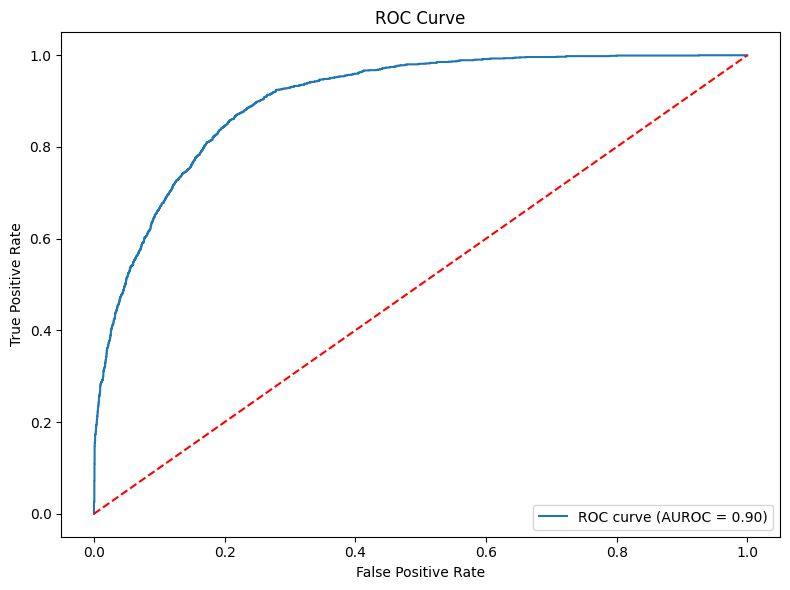

In [15]:
#ROC Curve visualization

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUROC = {auroc_score:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
